In [11]:
#### Import section ####
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2


from tqdm import tqdm #Progress bar


# To rezise images
import skimage
from skimage.transform import resize

# We will use datetime to name the tensorboard files
import datetime


# GPU Configuration
# We need  CUDA 11.2 & cuDNN 8.1 for Tensorflow 2.7!!!
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth set for GPUs")
    except RuntimeError as e:
        print(e)
else:
    print("No GPUs detected")


No GPUs detected


In [2]:
#### Image pre-processing ####
train_folder = "chest_xray/train/"
test_folder =  "chest_xray/test/"

# Load is True only at the first time
LOAD_FROM_IMAGES = False

def get_data(folder):
    X = []
    Y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['NORMAL']:
                label = 0
            elif folderName in ['PNEUMONIA']:
                label = 1
            for image_filename in tqdm(os.listdir(folder + folderName)):
                img_file = cv2.imread(folder + folderName + '/' + image_filename)
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (150, 150, 3),mode='constant',anti_aliasing=True)
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    Y.append(label)
    X = np.asarray(X)
    Y = np.asarray(Y)
    return X,Y


if LOAD_FROM_IMAGES:
    # We load the images to the arrays (only the first time and then we change LOAD to False)
    X_train, Y_train = get_data(train_folder)
    X_test, Y_test= get_data(test_folder)
    
    # We save the arrays in files
    np.save('xtrain.npy', X_train)
    np.save('ytrain.npy', Y_train)
    np.save('xtest.npy', X_test)
    np.save('ytest.npy', Y_test)
else:
    # We load the arrays previously saved
    X_train = np.load('xtrain.npy')
    Y_train = np.load('ytrain.npy')
    X_test = np.load('xtest.npy')
    Y_test = np.load('ytest.npy')

In [16]:
#### Designing the model ####
# We can change the number  of filters in the convolutions
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(1, activation='sigmoid') #Sigmoid because it's a binary classification, softmax is for multiple classification
])

# Note: The Dropout layer is a mask that cancels the contribution of some neurons to the next layer, 
# it is important in the training of CNNs because it prevents overfitting of the training data.
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 34, 34, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │        18,497 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,817 (292.25 KB)

 Trainable params: 74,817 (292.25 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)


# Training the model
history= model.fit(X_train, Y_train, epochs=5, validation_data = (X_test,Y_test), callbacks=[tensorboard_callback])

Epoch 1/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 29s 309ms/step - accuracy: 0.9685 - loss: 0.0743 - val_accuracy: 0.8029 - val_loss: 0.8938
Epoch 2/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 22s 259ms/step - accuracy: 0.9763 - loss: 0.0574 - val_accuracy: 0.7596 - val_loss: 1.1158
Epoch 3/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 22s 258ms/step - accuracy: 0.9788 - loss: 0.0519 - val_accuracy: 0.7917 - val_loss: 1.3130
Epoch 4/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 23s 271ms/step - accuracy: 0.9831 - loss: 0.0474 - val_accuracy: 0.8365 - val_loss: 0.8029
Epoch 5/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 21s 253ms/step - accuracy: 0.9755 - loss: 0.0801 - val_accuracy: 0.7708 - val_loss: 1.2613


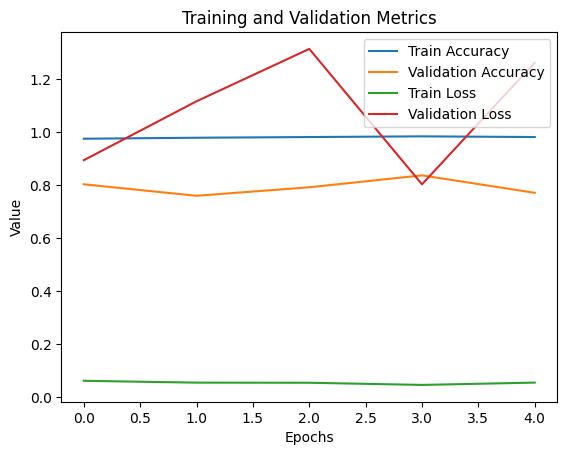

In [21]:
# Evaluating the model
train_accuracy = history.history['accuracy']
train_loss = history.history['loss']

val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')

# Graphics
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training and Validation Metrics')
plt.legend()
plt.show()


